In [ ]:
from PIL import Image
import numpy as np
from music21 import instrument, note, chord, stream

lowerBoundNote = 21
def column2notes(column):
    notes = []
    for i in range(len(column)):
        if column[i] > 255/2:
            notes.append(i+lowerBoundNote)
    return notes

resolution = 0.25
def updateNotes(newNotes,prevNotes): 
    res = {} 
    for note in newNotes:
        if note in prevNotes:
            res[note] = prevNotes[note] + resolution
        else:
            res[note] = resolution
    return res

def image2midi(image_path):
    with Image.open(image_path) as image:
        im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)
        try:
            print(image.size[1], image.size[0])
            im_arr = im_arr.reshape((image.size[1], image.size[0]))
        except:
            im_arr = im_arr.reshape((image.size[1], image.size[0],3))
            im_arr = np.dot(im_arr, [0.33, 0.33, 0.33])

    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model

    prev_notes = updateNotes(im_arr.T[0,:],{})
    for column in im_arr.T[1:,:]:
        notes = column2notes(column)
        # pattern is a chord
        notes_in_chord = notes
        old_notes = prev_notes.keys()
        for old_note in old_notes:
            if not old_note in notes_in_chord:
                new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
                new_note.storedInstrument = instrument.Piano()
                if offset - prev_notes[old_note] >= 0:
                    new_note.offset = offset - prev_notes[old_note]
                    output_notes.append(new_note)
                elif offset == 0:
                    new_note.offset = offset
                    output_notes.append(new_note)                    
                else:
                    print(offset,prev_notes[old_note],old_note)

        prev_notes = updateNotes(notes_in_chord,prev_notes)

        # increase offset each iteration so that notes do not stack
        offset += resolution

    for old_note in prev_notes.keys():
        new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
        new_note.storedInstrument = instrument.Piano()
        new_note.offset = offset - prev_notes[old_note]

        output_notes.append(new_note)

    prev_notes = updateNotes(notes_in_chord,prev_notes)

    midi_stream = stream.Stream(output_notes)
    
    name = image_path
    name.replace(".png",".mid")
    print(name)

    midi_stream.write('midi', 'composition.mid')

In [ ]:
import os
from PIL import Image
from matplotlib import pyplot as plt 
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def inv_sigmoid(x):
    return np.log(y/(1-y))

%matplotlib inline

path = '/content'
os.getcwd()
img_list = os.listdir(path)

def access_images(img_list,path,length):
    pixels = []
    imgs = []
    for i in range(length):
        if 'png' in img_list[i]:
          try:
            img = Image.open(path+'/'+img_list[i],'r')
            img = img.convert('1')
            pix = np.array(img.getdata())
            pix = pix.astype('float32')
            pix /= 255.0
            pixels.append(pix.reshape(106,106,1))
            imgs.append(img)
          except:
            pass
    return np.array(pixels),imgs

def show_image(pix_list):
    array = np.array(pix_list.reshape(106,106), dtype=np.uint8)
    new_image = Image.fromarray(array)
    new_image.show()
    
pixels,imgs = access_images(img_list,path,250)

In [ ]:
np.unique(pixels)

array([0., 1.], dtype=float32)

In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten,BatchNormalization
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
from IPython.display import clear_output
 
def define_discriminator(in_shape = (106,106,1)):
    model = Sequential()
    model.add(Conv2D(16, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(Dropout(0.5))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    model.add(Conv2D(16, (3,3), strides=(2, 2), padding='same'))
    model.add(Dropout(0.5))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.00002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
 
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 128 * 53 * 53
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((53, 53, 128)))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Conv2D(1, (7,7) , padding='same',activation = 'sigmoid'))
    return model
 
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model
 
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y
 
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=10):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            d_loss, _ = d_model.train_on_batch(X, y)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
            clear_output()

latent_dim = 10
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
print(pixels.shape)
train(g_model, d_model, gan_model, np.array(pixels), latent_dim)

In [ ]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


# load model
model = g_model
# generate images
latent_points = generate_latent_points(latent_dim,1)
# generate images
X = g_model.predict(latent_points)

array = np.array(X.reshape(106,106),dtype = np.uint8)
array*= 255
new_image = Image.fromarray(array,'L')
new_image = new_image.save('composition.png')

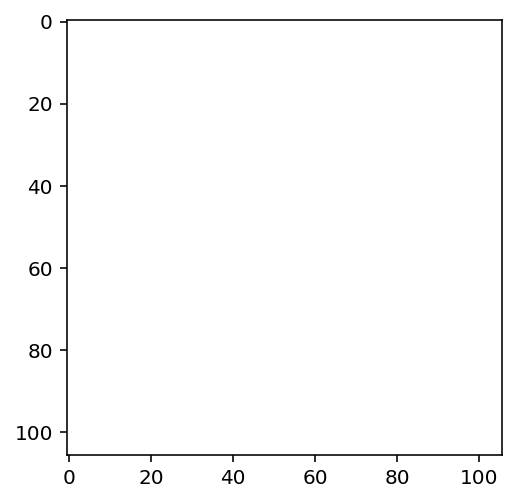

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(array.reshape(106,106), cmap='Greys',  interpolation='nearest')

plt.show()

In [ ]:
array.dtype

dtype('uint8')

In [ ]:
image2midi('composition.png')

106 106
composition.png


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [ ]:
np.unique(array)

array([0], dtype=uint8)

In [ ]:
!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
!fluidsynth -ni font.sf2 composition.mid -F output.wav -r 44100
from IPython.display import Audio
Audio('output.wav')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 15 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libqt5x11extras5 amd64 5.9.5-0ubuntu1 [8,596 B]
Get:5 http://archive.ubuntu.com/ubuntu bionic/uni

In [ ]:
model = Sequential()
n_nodes = 10 * 53 * 53
model.add(Dense(n_nodes, input_dim=latent_dim))
model.add(LeakyReLU(alpha=0.2))
model.add(Reshape((53, 53, 10)))
model.add(Dense(1024))
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
model.add(Dense(1024))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(1024))
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2D(1, (7,7) , padding='same',activation = 'sigmoid'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 28090)             308990    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 28090)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 53, 53, 10)        0         
_________________________________________________________________
dense_6 (Dense)              (None, 53, 53, 1024)      11264     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 53, 53, 1024)      0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 106, 106, 64)      1048640   
_________________________________________________________________
dense_7 (Dense)              (None, 106, 106, 1024)   